In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fairness as fm
import seaborn as sns
sns.set_theme(style="darkgrid")

# PVIs

/Users/jonathanvasquezverdugo/PHD-GMU/Research & Projects/DispaRisk/celeba/fairness.py:116: RuntimeWarning: Mean of empty slice.
  pos_priv = y_pred[(y_true == 1) & (protected_attr != unpriv_class)].mean() if priv_class is None else y_pred[(y_true == 1) & (protected_attr == priv_class)].mean()
/Users/jonathanvasquezverdugo/PHD-GMU/Research & Projects/DispaRisk/disparisk-env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.9933623885382226


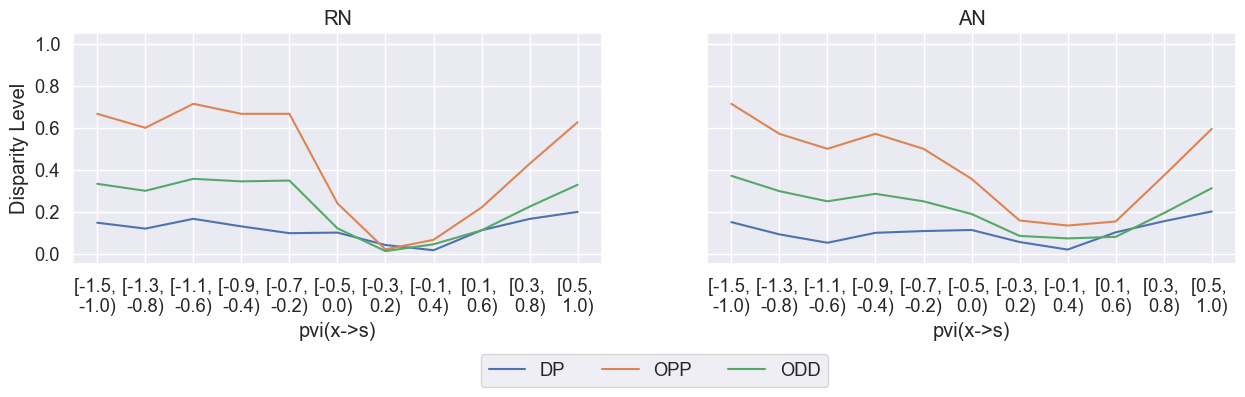

In [51]:
fig, axis = plt.subplots(1,2, figsize=(15,3), sharex=True, sharey=True)
sns.set(font_scale=1.2)

high_bound = 1.1
low_bound = -1.5

step = .2
overlap = .3

col = 0
sel_ave = 0
for model in ['resnet18','alexnet']:
    pvis = pd.read_csv(f'pvis_{model}_final.csv')
    pvis = pvis.sort_values(by='pvi')

    S_test = np.array(pvis[(pvis['pvi']>=low_bound) & (pvis['pvi']<=high_bound)]['sensitive'])
    Y_test = np.array(pvis[(pvis['pvi']>=low_bound) & (pvis['pvi']<=high_bound)]['real_Y'])
    pred_test = np.array(pvis[(pvis['pvi']>=low_bound) & (pvis['pvi']<=high_bound)]['pred'])
    metric_pve = np.array(pvis[(pvis['pvi']>=low_bound) & (pvis['pvi']<=high_bound)]['pvi'])

    sel_ave += len(metric_pve)/len(pvis)

    length_range = step+overlap

    freq_overall = []
    freq_unpr = []
    freq_pr = []
    thresholds = []
    thresholds_not_filtered=[]

    unpr_rate = []
    male_rate = []
    demp_overall = []
    eqodd_overall = []
    eqopp_overall = []
    selection_rate_all = []
    error_unpr_rate_all = []
    error_priv_rate_all = []
    acc_selected = []
    for r in range(int(low_bound*100), int(high_bound*100+1), int(step*100)):
        thr = r/100
        if (thr+length_range)>high_bound:continue
        thresholds_not_filtered.append(thr)
        selected = (metric_pve>=thr) & (metric_pve<(thr+length_range))
        acc_selected.append((acc_selected[-1])+sum(selected)/len(pvis) if len(acc_selected)>0 else sum(selected)/len(pvis))
        freq_overall.append(sum(selected)/len(metric_pve))
        freq_unpr.append(sum(selected & (S_test==1))/sum(selected))
        freq_pr.append(sum(selected & (S_test==0))/sum(selected))
        selection_rate_all.append(sum(pred_test[selected])/sum(selected))
        
        thresholds.append(thr)
        male_rate.append(sum(S_test[selected])/len(S_test[selected]) if len(S_test[selected]>0) else None)
        selection_rate_all.append(sum(pred_test[selected])/sum(selected))
        demp_overall.append(abs(fm.demographic_parity_dif(pred_test[selected],S_test[selected],1)))
        eqodd_overall.append(abs(fm.equal_odd_dif(Y_test[selected],pred_test[selected],S_test[selected],1)))
        eqopp_overall.append(abs(fm.equal_opp_dif(Y_test[selected],pred_test[selected],S_test[selected],1)))

    width = .15
    
    axis[col].plot(thresholds, demp_overall, label='DP')
    axis[col].plot(thresholds, eqopp_overall,  label='OPP')
    axis[col].plot(thresholds, eqodd_overall, label='ODD')
    
    axis[col].set_xticks(np.array([x/100 for x in  range(int(low_bound*100), int(high_bound*100+1), int(step*100))])[list(range(0,len(thresholds),1))], 
                np.array(['['+str(x)+', \n'+str(round(x+length_range,2))+')' for x in thresholds])[list(range(0, len(thresholds), 1))])
    
    axis[col].set_title(f'{"AN" if model=="alexnet" else "RN"}')
    axis[col].set_ylim((-0.05, 1.05))
    
    axis[col].set_xlabel('pvi(x->s)')
    if col==0:
        axis[col].set_ylabel('Disparity Level')
    col +=1
    
print(sel_ave/2)
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.35), ncol=3)
plt.show()